In [1]:
# Import Basics Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import *

In [2]:
# Read in training data from CSV
df_train = pd.read_csv('./Emotions/train.txt', sep=';')
df_train.columns =['Text', 'Sentiment']
df_train

,Text,Sentiment
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness
...,...,...
15994,i just had a very brief time in the beanbag an...,sadness
15995,i am now turning and i feel pathetic that i am...,sadness
15996,i feel strong and good overall,joy
15997,i feel like this was such a rude comment and i...,anger


In [3]:
# Downsample the training set to ~3,000 samples
percentage = 0.15
df_train_downsampled = df_train.sample(frac=percentage,random_state=0)
df_train_downsampled

,Text,Sentiment
8833,i die wont some man make me feel that lifes wo...,joy
223,i still second guess myself and still have a t...,joy
15839,i feel sorry for her father,sadness
6321,i guess which meant or so i assume no photos n...,sadness
14912,i was feeling when nick broke up with me over,sadness
...,...,...
12639,i cherish the heartbreak more then the love th...,sadness
15530,i feel that the people i have allocated my que...,joy
10109,i really wanna see her soon but i feel really ...,sadness
760,is that you feel it more than hear it and the ...,love


In [4]:
# Read in testing data from CSV
df_test = pd.read_csv('./Emotions/test.txt', sep=';')
df_test.columns =['Text', 'Sentiment']
df_test

,Text,Sentiment
0,im updating my blog because i feel shitty,sadness
1,i never make her separate from me because i do...,sadness
2,i left with my bouquet of red and yellow tulip...,joy
3,i was feeling a little vain when i did this one,sadness
4,i cant walk into a shop anywhere where i do no...,fear
...,...,...
1994,i just keep feeling like someone is being unki...,anger
1995,im feeling a little cranky negative after this...,anger
1996,i feel that i am useful to my people and that ...,joy
1997,im feeling more comfortable with derby i feel ...,joy


In [5]:
# Downsample the testing set to ~600 samples
percentage = 0.3
df_test_downsampled = df_test.sample(frac=percentage,random_state=0)
df_test_downsampled

,Text,Sentiment
405,i feel so honored today and i want to share th...,joy
1189,i noticed that i was feeling very stressed and...,anger
674,i feel safe with berry,joy
1358,im feeling quite positive in what i want to ac...,joy
810,i want to say i feel numb but if i was numb i ...,sadness
...,...,...
108,im feeling pretty disheartened by the whole thing,sadness
1294,i start to feel lethargic about blogging,sadness
1780,i had told gerry yesterday that if i feel isol...,sadness
2,i left with my bouquet of red and yellow tulip...,joy


In [6]:
# Check for Null Values
if ( not df_train_downsampled.isnull().values.any() ):
    print("Training Dataset has no NULL values.")
else:
    print("Removing samples in Training Set with NULL values")
    df_train_downsampled.dropna(subset = ["Text"], inplace=True)
    df_train_downsampled.dropna(subset = ["Sentiment"], inplace=True)
    print("Null values Exist In X,Y Training Set:", df_train_downsampled.isnull().values.any())

if ( not df_test_downsampled.isnull().values.any() ):
    print("Testing Dataset has no NULL values.")
else:
    print("Removing samples in Testing Set with NULL values")
    df_test_downsampled.dropna(subset = ["Text"], inplace=True)
    df_test_downsampled.dropna(subset = ["Sentiment"], inplace=True)
    print("Null values Exist In X,Y Training Set:", df_test_downsampled.isnull().values.any())

Training Dataset has no NULL values.
Testing Dataset has no NULL values.


In [7]:
# Get TrainX/Y and TestX/Y
TrainXdf=df_train_downsampled['Text']
TrainYdf=df_train_downsampled['Sentiment']

TestXdf=df_test_downsampled['Text']
TestYdf=df_test_downsampled['Sentiment']

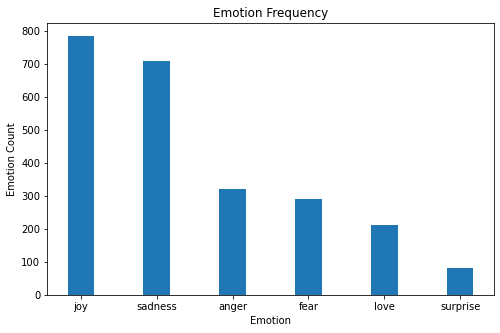

In [8]:
# Visual of Training Samples' Outcomes - Even Distribution of Outcomes
sent_count = TrainYdf.value_counts()
plt.figure(figsize=(8, 5))
w = 0.35  
plt.bar(x=np.arange(len(sent_count)), height=sent_count, width = w)

plt.xticks(np.arange(len(sent_count)), sent_count.index.tolist())
plt.xlabel('Emotion')
plt.ylabel('Emotion Count')
plt.title('Emotion Frequency')

plt.show()

In [9]:
# Convert sentiment values to numbers (i.e. joy is 0, sadness is 1, anger is 2, fear is 3, love is 4, surprise is 5)
TrainYdf.replace({"joy": 0, "sadness": 1, "anger":2, "fear":3, "love":4, "surprise":5}, inplace=True)
TestYdf.replace({"joy": 0, "sadness": 1, "anger":2, "fear":3, "love":4, "surprise":5}, inplace=True)
TrainYdf

8833     0
223      0
15839    1
6321     1
14912    1
        ..
12639    1
15530    0
10109    1
760      4
5655     3
Name: Sentiment, Length: 2400, dtype: int64

In [10]:
# "One-Hot Encoding" Function that converts the Tweets to Numerical Arrays
def oneHotEnc(Tweet):
    token_item = []

    for letter in Tweet:
        if ord(letter) >= ord('a') and ord(letter) <= ord('z'):
            token_item.append(ord(letter) - ord('a'))
        elif letter == ' ':
            token_item.append(-1)
        else:
            pass

    return token_item

# Function that Pre-Processes the Tweets
def PreProcess(tweets, method):
    pre_procc_tweets = []

    # Storing all punctuations using RE library like !;,"% etc
    re_puncs = re.compile('[%s]' % re.escape(string.punctuation))

    # Storing all stop words like a, an, the, when, there, this etc
    stop_word  = set(stopwords.words('english'))

    # Lemmatizing object
    lem = WordNetLemmatizer()

    # Using Porter Stemmer
    p_stem = PorterStemmer()

    for tweet in tweets:
        # Get words in tweet
        words = word_tokenize(str(tweet))

        # Converting all characters to lower case
        words_lower = [w.lower() for w in words]

        # Remove all punctuation
        words_lower_no_punc = [re_puncs.sub('', w) for w in words_lower]

        # Keep only alpha words
        words_lower_alpha = [i for i in words_lower_no_punc if i.isalpha()]

        # Removing all stop words
        words_lower_alpha_nostop = [w for w in words_lower_alpha if w not in stop_word]

        # Doing Lemmatizing of words
        words_lower_alpha_nostop_lemma = [lem.lemmatize(w) for w in words_lower_alpha_nostop]

        # Stemming process
        words_lower_alpha_nostop_lemma_stem = [p_stem.stem(w) for w in words_lower_alpha_nostop_lemma]

        # Convert back to string and (possibly) one-hot encode tweet
        pre_procc_str = ' '.join(words_lower_alpha_nostop_lemma_stem)
        if (method==1):
            procc_tweet = oneHotEnc(pre_procc_str)
        else:
            procc_tweet=pre_procc_str
        pre_procc_tweets.append(procc_tweet)
        
    return pre_procc_tweets

# Encoding method (1 for NGRAM, 0 for TOKENIZATION)
method = 0

# Max Number of features for Tokenization
max_features = 700

# Pre-Process the Tweets and Get Finalized Training and Testing Sets
TrainXdf = PreProcess(TrainXdf,method)
TestXdf = PreProcess(TestXdf,method)

if (method ==0):
    cnt = CountVectorizer(analyzer="word", ngram_range=(2,3), max_features=max_features)
    TrainXdf = cnt.fit_transform(TrainXdf).toarray()
    TestXdf=cnt.transform(TestXdf).toarray()

TrainYdf=np.array(TrainYdf)
TestYdf=np.array(TestYdf)

print(TrainXdf.shape)
print(TestXdf.shape)

(2400, 700)
(600, 700)


In [11]:
# Item Memory Generation Function, NGRAM
def itemMemGen_NGRAM(dim=10000, num_char=37):
    dictMem = np.random.randint(2, size=(num_char, dim), dtype='int32')
    return dictMem
# Item Memory Generation Function, TOKENIZATION
def itemMemGen_TOKEN(features, dim=10000):
    dictMem = np.random.randint(2, size=(features, dim), dtype='int32')
    return dictMem

# Hyperparamaters
HV_dim = 10000
num_supported_chars = 27

# Item Memory Generation
if (method ==1):
    itemMem = itemMemGen_NGRAM(dim=HV_dim, num_char=num_supported_chars)
else:
    itemMem = itemMemGen_TOKEN(features=len(TrainXdf[0]), dim=HV_dim)

In [12]:
# Function for Encoding a Tweet into a HV
def encode(tweet, itemMem, method, HV_dim=10000, n_gram_len=3):
    if (method==1):
        tweet_HV = np.zeros(HV_dim, dtype='int32')

        for ngram_start in range(0, len(tweet)-n_gram_len, 3):
            roll_value=n_gram_len
            for j in range(n_gram_len):
                letterHV = itemMem[tweet[ngram_start + j]]

                if (j==0):
                    product = letterHV
                elif (j==n_gram_len-1):
                    product = product * np.roll(letterHV, roll_value)
                    tweet_HV = np.add(tweet_HV, product)
                else:
                    product = product * np.roll(letterHV, roll_value)
                    
                roll_value = roll_value - 1

        HV_avg = np.average(tweet_HV)
        tweet_HV[tweet_HV > HV_avg] = 1
        tweet_HV[tweet_HV < HV_avg] = -1
        tweet_HV[tweet_HV == HV_avg] = 0
        return tweet_HV
    else:
        return tweet.dot(itemMem)

# HDC Training Function Creates Associative Memory
def train(X, Y, itemMem, HV_dim, sent_count, n_gram_len, method):
    assocMem = np.zeros((sent_count, HV_dim), dtype='int32')
    encodedTweets=[]
    tweet_idx = 0
    
    for tweet in X:
        tweet_HV = encode(tweet.reshape(1, len(tweet)), itemMem, method, HV_dim, n_gram_len)
        if (tweet_idx==0):
            print(tweet_HV.shape)
        assocMem[Y[tweet_idx]] = np.add(assocMem[Y[tweet_idx]], tweet_HV)
        tweet_idx += 1

    return assocMem

n_gram_len = 3
assocMem = train(TrainXdf, TrainYdf, itemMem, HV_dim, len(sent_count), n_gram_len, method)
assocMem

(1, 10000)


array([[604, 666, 728, ..., 686, 682, 506],
       [470, 667, 732, ..., 648, 683, 526],
       [253, 325, 309, ..., 272, 305, 244],
       [257, 273, 257, ..., 265, 318, 261],
       [134, 209, 222, ..., 215, 229, 140],
       [ 50,  73,  62, ...,  64,  68,  59]])

In [13]:
# Function Compares Input HV to Class HVs and Returns the Predicted Class
def get_prediction(assocMem, inputHV):
    pred = assocMem[0]
    maximum = np.NINF

    for index in range(len(assocMem)):
        similarity = cosine_similarity([inputHV, assocMem[index]])[0][1]  
        if (similarity > maximum):
            pred = index
            maximum = similarity

    return pred

# Function Tests the Model and Return Accuracy of Model
def test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method):
    correct_count = 0

    for index in range(len(TestXdf)):
        prediction = get_prediction(assocMem, encode(TestXdf[index], itemMem, method, HV_dim, n_gram_len))
        if (TestYdf[index] == prediction):
            correct_count += 1
            
    accuracy = (correct_count / len(TestYdf)) * 100
    return accuracy

# One-Shot Training Results
one_shot_accuracy=test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
print("One Shot Accuracy: ", one_shot_accuracy)

One Shot Accuracy:  51.33333333333333


In [14]:
def retrain(X, Y, itemMem, assocMem, HV_dim, n_gram_len, method, alpha):
    tweet_index = 0
    print("start")
    for tweet in X:
        tweet_HV = encode(tweet, itemMem, method, HV_dim, n_gram_len)
        prediction = get_prediction(assocMem, tweet_HV)
        if prediction != Y[tweet_index]:
            assocMem[Y[tweet_index]] = np.add(assocMem[Y[tweet_index]], alpha * tweet_HV)
            assocMem[prediction] = np.subtract(assocMem[prediction], alpha * tweet_HV)
        tweet_index += 1
        if(tweet_index%10000 == 0):
            print("still going", tweet_index)
    return assocMem

# Re-Train Model
num_epochs = 20
print('-------- Retraining Model: ', num_epochs, ' Epochs --------')
for epoch in range(num_epochs):
    assocMem = retrain(TrainXdf, TrainYdf ,itemMem, assocMem, HV_dim, n_gram_len, method, alpha = num_epochs - epoch)
    acc = test(HV_dim, n_gram_len, itemMem, assocMem, TestXdf, TestYdf, method)
    print('Epoch ', (epoch+1), ': ', acc)

-------- Retraining Model:  20  Epochs --------
start
Epoch  1 :  48.0
start
Epoch  2 :  47.16666666666667
start
Epoch  3 :  51.33333333333333
start
Epoch  4 :  50.16666666666667
start
Epoch  5 :  50.0
start
Epoch  6 :  48.66666666666667
start
